## Projet IAS - Data Processing

In [298]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

### 1. Importation et filtrage les données

In [299]:
df = pd.read_csv('mouvement.csv', sep=';')
df.head()

,InventoryLogDetailId,BatchType,TransactionDate,Quantity,FromLocationId,ToLocationId,FromQuantityBefore,FromQuantityAfter,ToQuantityBefore,ToQuantityAfter,Name,ProdId
0,100,6,2019-08-08 01:36:28.523,80.0,NaN,100.0,NaN,NaN,0.0,80.0,ZINNIA-F CP ENR B/3*28 FAMY CARE LTD,4968
1,101,6,2019-08-08 01:36:28.523,12.0,NaN,100.0,NaN,NaN,0.0,12.0,ZINNIA-F CP ENR DET PL/28 FAMY CARE LTD,4969
2,102,6,2019-08-08 14:56:17.520,2.0,NaN,100.0,NaN,NaN,0.0,2.0,"ALLERGODIL 0,127MG/DOSE SPRAY NASAL FL/17ML MYLAN",221
3,103,6,2019-08-08 14:56:17.520,2.0,NaN,100.0,NaN,NaN,0.0,2.0,BIRODOGYL B/10 CP PELLIC SANOFI,815
4,104,6,2019-08-08 14:56:17.520,1.0,NaN,100.0,NaN,NaN,0.0,1.0,CARVEDI-DENK 25MG CP B/30 DENK PHARMA,1062


**Explication du colonne 'BatchType'**

* BatchType = 1 : **Ajustement de stock** (positif ou négatif)

C'est un mouvement de stock qui est d'origine très variable. Il peut s'agir d'une erreur de vente/achat, d'un retour de produit, d'un produit périmé et aussi d'autres cas inexplicables, etc. Ce type de mouvement est pertinent car il indique l'état de stock de la pharmacie avant et après la vente.

* BatchType = 2 signifie **Transfert de stock** (neutre)

Il s'agit d'un mouvement de stock entre les emplacement internes de la pharmacie. Cela ne nous intéresse pas car il n'a aucun effet sur la variation du stock.

* BatchType = 3 signifie **Assortiment** (négatif car sortie de stock)
    Ce type de mouvement est pertinent car il indique l'états de stock de la pharamacie avant et après la vente.

* BatchType = 4 signifie une **Expédition**. 

Il indique la quantité de produits assortis prêts à être expédiés qui est appelé 'PICKED'. Ce mouvement ne nous intéresse pas car il est temporaire et n'a pas d'effet sur la variation du stock.
La suppression de ce mouvement est très importante car il s'apparie toujours au mouvement BatchType 3 (Assortiment). Donc ça va diminuer de moitié le nombre de lignes de ces deux catégories (3 et 4).

* BatchType = 5 signifie **Réapprovisionnement** (en général positif sauf erreur de saisie)

Il s'agit d'un mouvement de commander à nouveau des produits pour que le stock soit suffisant et permette de répondre à la demande. Cela aura un impact sur le stock de la pharmacie.

* BatchType = 6 signifie **Réception** (généralement positif sauf erreur de saisie)
Il s'agit d'un mouvement de stock qui indique que la pharmacie a reçu des produits achetés depuis les grossistes. Cela aura un impact sur le stock de la pharmacie.

Les lignes à éliminer sont celles qui ont BatchType = 2 et 4.

In [300]:
# Afficher les catégories de valeurs de la colonne 'BatchType'
df['BatchType'].unique()

array([6, 3, 4, 5, 1, 7, 2], dtype=int64)

In [301]:
# Comparer les nombres des 'BatchType' de catégorie 2 et 4 par rapport au total
df.shape[0], df[df['BatchType'].isin([2, 4])].shape[0]

(1474451, 638706)

In [302]:
# Eliminer les lignes avec 'BatchType' 2 et 4
df = df[~df['BatchType'].isin([2, 4])]

In [303]:
# Vérification
df.shape[0], df[df['BatchType'].isin([2, 4])].shape[0]

(835745, 0)

### 2. Remplir les 2 colonnes "last_stock" et "current_stock"

In [304]:
def fill_columns(row):
    if row['BatchType'] in [1, 5]:
        if np.isnan(row['FromLocationId']):
            row['LastStock'] = row['ToQuantityBefore']
            row['CurrentStock'] = row['ToQuantityAfter']
        else:
            row['Quantity'] *= -1
            row['LastStock'] = row['FromQuantityBefore']
            row['CurrentStock'] = row['FromQuantityAfter']
    elif row['BatchType'] == 3:
        row['Quantity'] *= -1
        row['LastStock'] = row['FromQuantityBefore']
        row['CurrentStock'] = row['FromQuantityAfter']
    elif row['BatchType'] == 6:
        if np.isnan(row['FromLocationId']):
            row['LastStock'] = row['ToQuantityBefore']
            row['CurrentStock'] = row['ToQuantityAfter']
        else:
            row['Quantity'] *= -1
            row['LastStock'] = row['FromQuantityBefore']
            row['CurrentStock'] = row['FromQuantityAfter']
    else:
        row['LastStock'] = 0
        row['CurrentStock'] = 0
    return row

In [305]:
# Create the two new columns and apply the function to each row
df['LastStock'] = 0
df['CurrentStock'] = 0
df = df.apply(fill_columns, axis=1)

# Display the updated DataFrame
df.head()

,InventoryLogDetailId,BatchType,TransactionDate,Quantity,FromLocationId,ToLocationId,FromQuantityBefore,FromQuantityAfter,ToQuantityBefore,ToQuantityAfter,Name,ProdId,LastStock,CurrentStock
0,100,6,2019-08-08 01:36:28.523,80.0,NaN,100.0,NaN,NaN,0.0,80.0,ZINNIA-F CP ENR B/3*28 FAMY CARE LTD,4968,0.0,80.0
1,101,6,2019-08-08 01:36:28.523,12.0,NaN,100.0,NaN,NaN,0.0,12.0,ZINNIA-F CP ENR DET PL/28 FAMY CARE LTD,4969,0.0,12.0
2,102,6,2019-08-08 14:56:17.520,2.0,NaN,100.0,NaN,NaN,0.0,2.0,"ALLERGODIL 0,127MG/DOSE SPRAY NASAL FL/17ML MYLAN",221,0.0,2.0
3,103,6,2019-08-08 14:56:17.520,2.0,NaN,100.0,NaN,NaN,0.0,2.0,BIRODOGYL B/10 CP PELLIC SANOFI,815,0.0,2.0
4,104,6,2019-08-08 14:56:17.520,1.0,NaN,100.0,NaN,NaN,0.0,1.0,CARVEDI-DENK 25MG CP B/30 DENK PHARMA,1062,0.0,1.0


In [306]:
df.tail()

,InventoryLogDetailId,BatchType,TransactionDate,Quantity,FromLocationId,ToLocationId,FromQuantityBefore,FromQuantityAfter,ToQuantityBefore,ToQuantityAfter,Name,ProdId,LastStock,CurrentStock
1474441,1507682,3,2025-04-06 16:43:31.793,-2.0,101.0,1.0,298.0,296.0,0.0,2.0,FERVEX AD AVEC SUCRE SACH DET UPSA,1863,298.0,296.0
1474443,1507684,3,2025-04-06 16:43:35.063,-1.0,101.0,1.0,59.0,58.0,0.0,1.0,PARACETAMOL 500MG DET PL/10,3616,59.0,58.0
1474444,1507685,3,2025-04-06 16:43:35.063,-1.0,101.0,1.0,8.0,7.0,0.0,1.0,PRESA PRESERVATIF B/3,6590,8.0,7.0
1474447,1507688,3,2025-04-06 16:43:37.327,-1.0,101.0,1.0,79.0,78.0,0.0,1.0,NAUTAMINE 90MG CP DET SANOFI AVENTIS,3248,79.0,78.0
1474449,1507690,3,2025-04-06 16:43:39.933,-1.0,101.0,1.0,86.0,85.0,0.0,1.0,"SSI 0,9% FL/500ML POCHE PLASTIQUE",4342,86.0,85.0


In [307]:
df[(df['BatchType']==6) & df['FromLocationId'].isnull()].head(2)

,InventoryLogDetailId,BatchType,TransactionDate,Quantity,FromLocationId,ToLocationId,FromQuantityBefore,FromQuantityAfter,ToQuantityBefore,ToQuantityAfter,Name,ProdId,LastStock,CurrentStock
0,100,6,2019-08-08 01:36:28.523,80.0,NaN,100.0,NaN,NaN,0.0,80.0,ZINNIA-F CP ENR B/3*28 FAMY CARE LTD,4968,0.0,80.0
1,101,6,2019-08-08 01:36:28.523,12.0,NaN,100.0,NaN,NaN,0.0,12.0,ZINNIA-F CP ENR DET PL/28 FAMY CARE LTD,4969,0.0,12.0


In [308]:
df[(df['BatchType']==6) & df['FromLocationId']].head(2)

,InventoryLogDetailId,BatchType,TransactionDate,Quantity,FromLocationId,ToLocationId,FromQuantityBefore,FromQuantityAfter,ToQuantityBefore,ToQuantityAfter,Name,ProdId,LastStock,CurrentStock
1299,1404,6,2019-08-12 11:50:31.353,-10.0,100.0,NaN,8.0,-2.0,NaN,NaN,YENDOL SACH DET,4934,8.0,-2.0
1376,1481,6,2019-08-12 13:12:08.780,-16.0,100.0,NaN,9.0,-7.0,NaN,NaN,FERVEX AD AVEC SUCRE SACH DET UPSA,1863,9.0,-7.0


### 3. Mapping ProdId-Name

In [309]:
item_map = pd.read_csv('../data/ProductIdMapp.csv', sep=',')
item_map.head()

,ProdId,ItemName
0,100,MULTIVITAMINES GLOBAL 12 VIT+ 7 OLIGO ELEMENTS...
1,102,804 AIDE MINCEUR TRIPLE ACTION CP B/30 3CHENE
2,103,804 BRULE GRAISSE SOL BUV STABILISATEUR FL/500ML
3,104,804 PACK MINCEUR
4,105,804 SOUPE B/300G LEGUMES


In [310]:
item_map.set_index('ProdId', inplace=True)
item_map = item_map.rename(columns={'ItemName': 'Name'})
item_map.head()

,Name
ProdId,
100,MULTIVITAMINES GLOBAL 12 VIT+ 7 OLIGO ELEMENTS...
102,804 AIDE MINCEUR TRIPLE ACTION CP B/30 3CHENE
103,804 BRULE GRAISSE SOL BUV STABILISATEUR FL/500ML
104,804 PACK MINCEUR
105,804 SOUPE B/300G LEGUMES


### 4. Selection des produits selon **les quantités dynamiques** et les **nombres de mouvements**

**4.1. Calcule du quantité moyenne de surstock et du nombre de mouvement**

In [311]:
# Calculer la moyenne des quantités par produit
s_1 = df.copy()

s_1 = s_1[['ProdId', 'Quantity']].groupby('ProdId').agg(
    Moves=('ProdId', 'count'),
    QuantityMean=('Quantity', 'mean')
).reset_index()


In [312]:
s_1.head()

,ProdId,Moves,QuantityMean
0,100,77,0.025974
1,102,12,0.000000
2,103,4,0.000000
3,104,33,0.000000
4,105,26,0.038462


In [313]:
s_1.duplicated().sum()

0

In [314]:

s_1.sort_values(by='QuantityMean', ascending=False, inplace=True, ignore_index=True)
s_1.head()

,ProdId,Moves,QuantityMean
0,6222,6,250.000000
1,5382,2,250.000000
2,6214,12,232.916667
3,5524,7,221.571429
4,5559,1,200.000000


In [315]:
s_1.describe()

,ProdId,Moves,QuantityMean
count,5885.000000,5885.000000,5885.000000
mean,4189.507052,142.012744,0.425650
std,2280.022359,454.631319,7.839451
min,100.000000,1.000000,-9.315789
25%,2151.000000,8.000000,0.000000
50%,4420.000000,31.000000,0.000000
75%,6184.000000,124.000000,0.040541
max,7779.000000,16886.000000,250.000000


D'après ces résultat, on remarque encore la présence des quantité moyennes négatives. Alors qu'on ne s'intérèsse qu'aux produits dont les quantités moyennes sont positives qui son succeptibles d'être en surstock.

In [316]:
s_1[s_1['QuantityMean'] > 0].shape[0], s_1[s_1['QuantityMean'] < 0].shape[0]

(2829, 891)

On a 2829 produits succeptibles en surstock contre 891 qui sont équilibrés (0) ou négatifs.

In [317]:
# Sélection des produits avec une quantité moyenne positive
s_2 = s_1[s_1['QuantityMean'] > 0].copy()
s_2.head()

,ProdId,Moves,QuantityMean
0,6222,6,250.000000
1,5382,2,250.000000
2,6214,12,232.916667
3,5524,7,221.571429
4,5559,1,200.000000


In [318]:
s_2.describe()

,ProdId,Moves,QuantityMean
count,2829.000000,2829.000000,2829.000000
mean,4326.761046,165.472959,0.936126
std,2350.625081,415.143695,11.282164
min,100.000000,1.000000,0.000803
25%,2235.000000,15.000000,0.017045
50%,4615.000000,56.000000,0.044444
75%,6481.000000,166.000000,0.142857
max,7779.000000,9238.000000,250.000000


9699.85 262.4999598715891


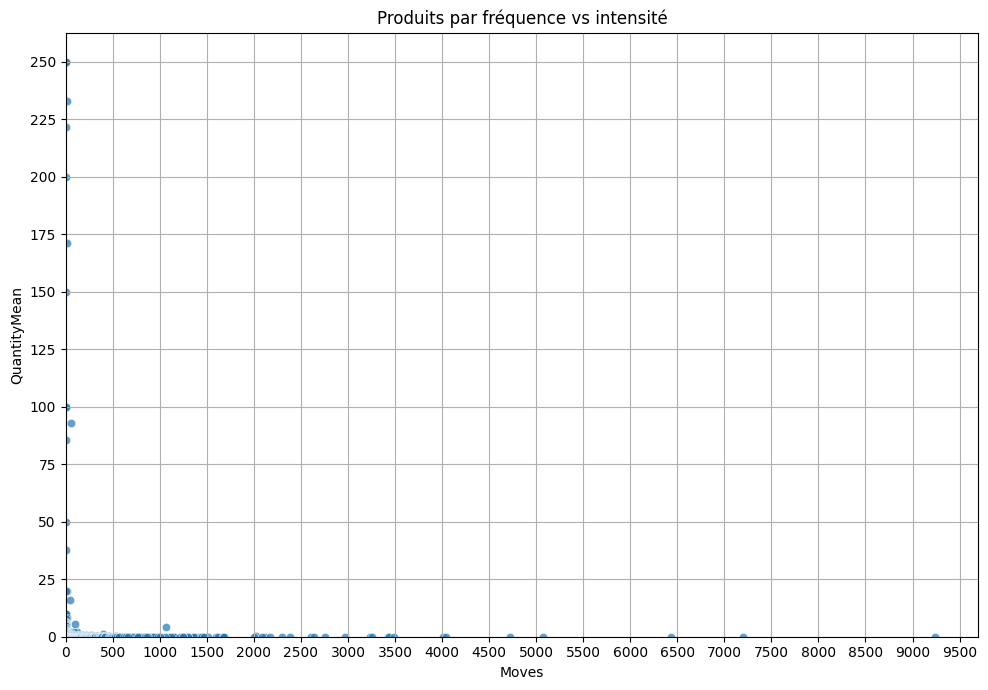

In [319]:
plt.figure(figsize=(10, 7))
ax = sns.scatterplot(
    data=s_2,
    x='Moves',
    y='QuantityMean',
    sizes=(20, 200),
    alpha=0.7
)
xmax, ymax = ax.get_xlim(), ax.get_ylim()
print(xmax[1], ymax[1])
plt.title("Produits par fréquence vs intensité")
plt.xlabel("Moves")
plt.ylabel("QuantityMean")
plt.xlim(0, xmax[1])
plt.ylim(0, ymax[1])
plt.xticks(range(0, int(xmax[1]), 500))
plt.yticks(range(0, int(ymax[1]), 25))
plt.grid(True)
plt.tight_layout()
plt.show()


D'après la visualisation, la plupart des produits en surstock ont peu de mouvements. Et ceux qui ont beaucoup de mouvements sont en général équilibrés ou négatifs. Pour la suite, on va isoler l'étude des produits qui sont en surstock mais peu de mouvements par rapport aux reste.

**4.2. Analyse du Groupe 1 : Produits en surstock avec peu de mouvements**

In [320]:
G1 = s_2[s_2['QuantityMean'] > 10].copy()
G1.head()

,ProdId,Moves,QuantityMean
0,6222,6,250.000000
1,5382,2,250.000000
2,6214,12,232.916667
3,5524,7,221.571429
4,5559,1,200.000000


In [321]:
G1.describe()

,ProdId,Moves,QuantityMean
count,16.000000,16.000000,16.000000
mean,5738.187500,10.812500,124.838064
std,1631.485876,15.263109,86.276924
min,111.000000,1.000000,15.813953
25%,5523.750000,2.000000,46.875000
50%,6069.000000,6.500000,100.000000
75%,6407.250000,10.500000,205.392857
max,7628.000000,53.000000,250.000000


In [322]:
# Récupérer les noms des produits G1
G1.join(item_map, on='ProdId')

,ProdId,Moves,QuantityMean,Name
0,6222,6,250.000000,BOUTEILLE PET 0.5 L RONDE
1,5382,2,250.000000,MASQUE COQUE DET
2,6214,12,232.916667,BOUCHON 28MM
3,5524,7,221.571429,BOUCHONS PET
4,5559,1,200.000000,FLACON A POMPE COULEUR BRUN AMBRE VIDE 300ML
5,5925,10,171.000000,FLACON PET 125ML AMBRE PLASTIMA
6,6473,1,150.000000,FLACON PET 100ML AMBRE PLASTIMA
7,6213,7,100.000000,FLACON 1L VERT
8,5523,3,100.000000,BOUTEILLE PET 1L RONDE
9,5485,53,92.830189,ALCOOL ETHYLIQUE 96 MESURE EN L ALPHA


**4.3. Analyse du Groupe 2 : Produits avec beaucoup de mouvements et peu de surstock**

In [323]:
G2 = s_2[(s_2['Moves'] > 1000) & (s_2['QuantityMean'] > 0.025)].copy()
G2.head(10).sort_values(by='QuantityMean', ascending=False, ignore_index=True)

,ProdId,Moves,QuantityMean
0,5054,1064,4.240602
1,2153,2028,0.323964
2,1862,4720,0.087076
3,1863,3423,0.077125
4,6080,1151,0.069505
5,5449,1239,0.050847
6,1837,1110,0.036036
7,4180,1144,0.027972
8,4342,9238,0.026737
9,3006,1270,0.025984


In [324]:
G2.describe()

,ProdId,Moves,QuantityMean
count,10.000000,10.000000,10.000000
mean,3582.600000,2638.700000,0.496585
std,1638.423375,2623.973537,1.318505
min,1837.000000,1064.000000,0.025984
25%,1935.500000,1145.750000,0.029988
50%,3593.000000,1254.500000,0.060176
75%,4876.000000,3074.250000,0.084589
max,6080.000000,9238.000000,4.240602


<Axes: ylabel='Moves'>

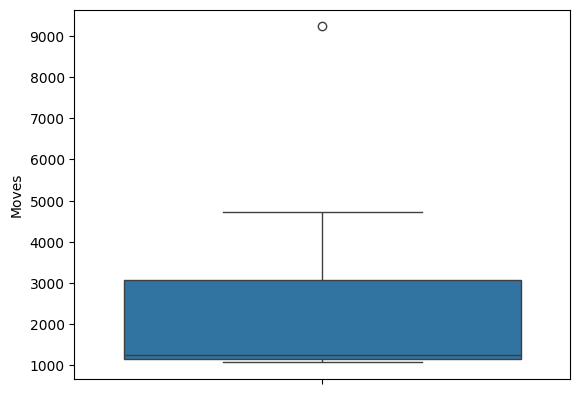

In [325]:
sns.boxplot(data=G2['Moves'])

<Axes: xlabel='Moves', ylabel='QuantityMean'>

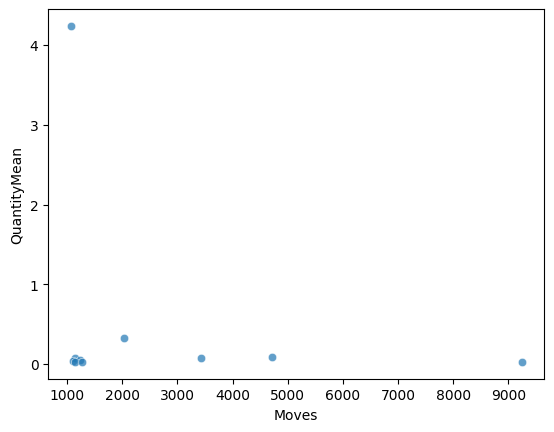

In [326]:
sns.scatterplot(
    data=G2,
    x='Moves',
    y='QuantityMean',
    sizes=(20, 200),
    alpha=0.7
)

**4.4. Sélection dans un nouveau dataframe les données des produits du Groupe 2** 

In [327]:
df2 = df[['TransactionDate', 'ProdId', 'CurrentStock']].copy()
df2 = df2[df2['ProdId'].isin(G2['ProdId'])]
df2.head()

,TransactionDate,ProdId,CurrentStock
177,2019-08-09 18:34:05.580,4342,-1.0
459,2019-08-10 15:06:09.357,4342,29.0
466,2019-08-10 15:06:09.357,4180,100.0
876,2019-08-10 18:18:42.610,4342,28.0
1024,2019-08-10 20:20:31.837,1862,-1.0


In [328]:
df2.describe()

,ProdId,CurrentStock
count,26387.000000,26387.000000
mean,3388.366468,48.612688
std,1384.574066,59.440240
min,1837.000000,-330.000000
25%,1863.000000,22.000000
50%,4180.000000,42.000000
75%,4342.000000,67.000000
max,6080.000000,2407.000000


### 5. Normalisation des données

In [329]:
df2['TransactionDate'].dtypes

dtype('O')

In [330]:
df2['TransactionDate'] = pd.to_datetime(df2['TransactionDate'])
df2['TransactionDate'].dtypes

dtype('<M8[ns]')

In [331]:
df2.set_index('TransactionDate', inplace=True)
df2.head()

,ProdId,CurrentStock
TransactionDate,,
2019-08-09 18:34:05.580,4342,-1.0
2019-08-10 15:06:09.357,4342,29.0
2019-08-10 15:06:09.357,4180,100.0
2019-08-10 18:18:42.610,4342,28.0
2019-08-10 20:20:31.837,1862,-1.0


In [332]:
# Pivoter la table pour obtener une série temporelle par produit
df3 = df2.pivot_table(index='TransactionDate', columns='ProdId', values='CurrentStock')
df3.head(20)

ProdId,1837,1862,1863,2153,3006,4180,4342,5054,5449,6080
TransactionDate,,,,,,,,,,
2012-11-23 12:56:36.140,NaN,NaN,NaN,NaN,NaN,NaN,NaN,33.0,NaN,NaN
2012-11-23 13:42:31.163,NaN,NaN,NaN,NaN,NaN,NaN,36.0,NaN,NaN,NaN
2012-11-23 14:00:56.870,NaN,NaN,NaN,NaN,NaN,NaN,35.0,NaN,NaN,NaN
2012-11-23 14:02:10.913,NaN,NaN,NaN,NaN,NaN,NaN,34.0,NaN,NaN,NaN
2012-11-23 14:02:13.373,NaN,7.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-08-09 18:34:05.580,NaN,NaN,NaN,NaN,NaN,NaN,-1.0,NaN,NaN,NaN
2019-08-10 15:06:09.357,NaN,NaN,NaN,NaN,NaN,100.0,29.0,NaN,NaN,NaN
2019-08-10 18:18:42.610,NaN,NaN,NaN,NaN,NaN,NaN,28.0,NaN,NaN,NaN
2019-08-10 20:20:31.837,NaN,-1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [333]:
""" def fill_nan(df):
    dftest = df.copy()
    for col in dftest.columns:
        temp = -1e9
        nancount = 0

        for key, value in dftest[col].items():
            if not pd.isna(value):
                temp = value
                if nancount > 0:
                    dftest.loc[dftest.index[:nancount], col] = temp
                    nancount = 0
            else: 
                if temp != -1e9:
                    dftest.loc[key, col] = temp
                else:
                    nancount += 1
    return dftest """

' def fill_nan(df):\n    dftest = df.copy()\n    for col in dftest.columns:\n        temp = -1e9\n        nancount = 0\n\n        for key, value in dftest[col].items():\n            if not pd.isna(value):\n                temp = value\n                if nancount > 0:\n                    dftest.loc[dftest.index[:nancount], col] = temp\n                    nancount = 0\n            else: \n                if temp != -1e9:\n                    dftest.loc[key, col] = temp\n                else:\n                    nancount += 1\n    return dftest '

In [334]:
df4 = df3.copy()
df4 = df4.ffill().bfill()
df4.head(20)

ProdId,1837,1862,1863,2153,3006,4180,4342,5054,5449,6080
TransactionDate,,,,,,,,,,
2012-11-23 12:56:36.140,10.0,7.0,-2.0,20.0,30.0,100.0,36.0,33.0,10.0,50.0
2012-11-23 13:42:31.163,10.0,7.0,-2.0,20.0,30.0,100.0,36.0,33.0,10.0,50.0
2012-11-23 14:00:56.870,10.0,7.0,-2.0,20.0,30.0,100.0,35.0,33.0,10.0,50.0
2012-11-23 14:02:10.913,10.0,7.0,-2.0,20.0,30.0,100.0,34.0,33.0,10.0,50.0
2012-11-23 14:02:13.373,10.0,7.0,-2.0,20.0,30.0,100.0,34.0,33.0,10.0,50.0
2019-08-09 18:34:05.580,10.0,7.0,-2.0,20.0,30.0,100.0,-1.0,33.0,10.0,50.0
2019-08-10 15:06:09.357,10.0,7.0,-2.0,20.0,30.0,100.0,29.0,33.0,10.0,50.0
2019-08-10 18:18:42.610,10.0,7.0,-2.0,20.0,30.0,100.0,28.0,33.0,10.0,50.0
2019-08-10 20:20:31.837,10.0,-1.0,-2.0,20.0,30.0,100.0,28.0,33.0,10.0,50.0


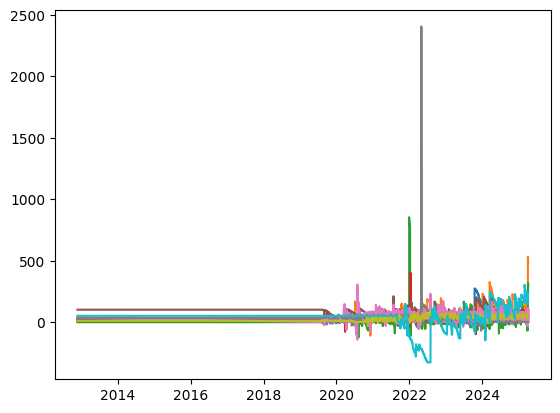

In [335]:
plt.plot(df4)

### 4. Exportation en CSV